In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib
from scipy import fftpack as spfft # for computing spectra
import scipy.signal as spsig
from scipy.io.wavfile import write

import resampy
from subprocess import call

import IPython.display as ipd

%matplotlib inline

# Set plot fontsize
matplotlib.rcParams.update({"font.size": 14})

%config InlineBackend.figure_formats = ["svg"]

Direct sonification is simply the process of changing the time scale of a signal to transpose it to the audible range. The data should therefore have similarities with sound waves in air, that is:

 - oscillations around an average value (better if this value is 0), a.k.a "stationary" data. 
 - not a vast range of amplitudes in the thing of interest
 - enough cycles to produce sound at the new frequency. 

We take the example of seismic data... but they could be many other things, e.g.:

[planetary:] 

 - ocean waves, tidal data
 - electro-magnetic waves (solar winds?)
 - gravitational waves
 - planetary orbital positions
 
[biological:] 

 - blood pressure
 - ekg brain waves
 
[sociological:] 
 - stock markets (detrended)?  

# EXAMPLE 1: a large earthquake 


## 1. Get the data (and in to python):

In [3]:
DirIn = "../data_nogit/seismic_data/"
DirOut = "../output_nogit/"

# (get the data first from the google drive for class-- and put it in the DirIn )
# This is the Tohoku earthquake (2011), recorded by a seimic station located in Central USA
FileNameIn = "P39A.BHZ"  # Note that this data has been pre-processed (instrument response removal)
fs = 20  # Datatype BHZ is sampled at 20 Hz
# In this case, you need to get the info from the data source. )

data = np.loadtxt(DirIn + FileNameIn)
duration = len(data) / fs
print(f"We have {len(data)} data points at a sampling frequency fs of {fs:.0f}Hz.")
print(f"We have {int(duration)} seconds of data!")
print(f"... which is {duration / 3600.:.1f} hours of data!")

# make time vectors for plotting purposes only
t = np.arange(0, duration, 1.0 / fs)  # in seconds
t_hours = np.arange(0, duration / 3600, 1.0 / fs / 3600)  # in hours


We have 1008000 data points at a sampling frequency fs of 20Hz.
We have 50400 seconds of data!
... which is 14.0 hours of data!


In [7]:
# Compute the spectrum

###### some useful prerequisites...

# 1) force the signal's mean value to be zero (to protect your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# a simple way is to normalize the data according to its maximum amplitude value
# data = data/np.amax(data) # This is dangerous, peak values can be negative, too
# better to do it THIS way:  
data_n = data/np.amax(np.absolute(data))

# Nfft is the number of frequencies to calculate in a discrete signal (i.e. in a computer)
Nfft = len(data_n)
f = np.arange(1/Nfft,fs/2,fs/Nfft) # to get the actual frequency values
S = spfft.fft(data,Nfft) 
S = S[:int(Nfft/2)] # remove any information from frequencies higher than Nyquist (half the sampling rate)
#https://en.wikipedia.org/wiki/Nyquist_frequency

print(f"Frequency content ranges from {f[0]:.2e}Hz to {f[-1]:.2f}Hz... (Nyquist frequency)")
print(f"Log frequency content ranges from {np.log10(f[0]):.2f}[log10(Hz)] to {np.log10(f[-1]):.2f}[log10(Hz)]")

Frequency content ranges from 9.92e-07Hz to 10.00Hz... (Nyquist frequency)
Log frequency content ranges from -6.00[log10(Hz)] to 1.00[log10(Hz)]
log Frequency content ranges from -6.003460532109506 to 0.9999991813885979 [log10(Hz)]


(-4.965303215228903,
 1.2840602975440336,
 -201.96264609633565,
 33.60022848972566)

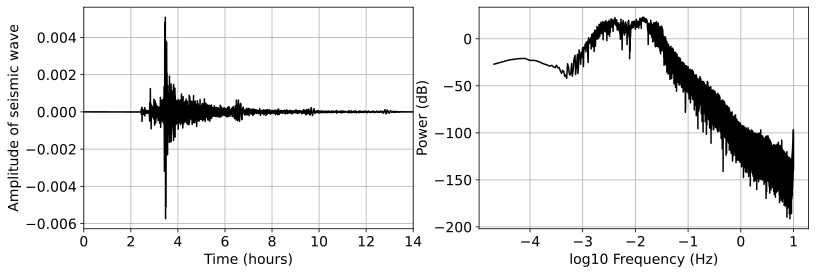

In [8]:
# waveform
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(t_hours, data, "k")
plt.xlabel("Time (hours)")
plt.ylabel("Amplitude of seismic wave")
plt.grid()
plt.xlim([0, duration / 3600])

# spectrum:
plt.subplot(1, 2, 2)
# plt.plot(f,20*np.log10(np.absolute(S)),'k')
plt.plot(np.log10(f[1:-1]), 20 * np.log10(np.absolute(S[1:-1])), "k")
plt.xlabel("log10 Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.axis()


In [14]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# or
duration = len(data) / fs
numwindows = 1000
WindowDur = duration / numwindows


WindowLength = int(
    WindowDur * fs
)  # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! (it could be to make it faster)

print(f"Window duration in seconds: {WindowDur:.2f}sec.")
print(f"Window length in samples: {WindowLength:d}spl.")

# Window overlap: The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)
# Eric says the optimal is the number of points - 1 ! (not necessarily, I just said that for the specific application with SpecUFEX)
# Overlap = int(WindowLength/2)  # 50% overlap:  quick but has some aliasing/artifacts
# Overlap = int(WindowLength-1)  # length - 1 !  TOO much for this machine!
Overlap = int(0.5 * WindowLength)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(
    data_n, fs, nperseg=WindowLength, noverlap=Overlap,# nfft=NfftSTFT
)
# also provides associated f and t vectors!
print(f"The frequency axis has {len(fSTFT):d} elements, ranging from {fSTFT.min():.2e}Hz to {fSTFT.max():.2f}Hz.")
print(f"The time axis has {len(tSTFT):d} elements, ranging from {tSTFT.min()}s to {tSTFT.max()}s.")
print(f"The shape of the STFT matrix is: {STFT.shape}")


Window duration in seconds: 50.40sec.
Window length in samples: 1008spl.
The frequency axis has 505 elements, ranging from 0.00e+00Hz to 10.00Hz.
The time axis has 1999 elements, ranging from 25.2s to 50374.8s.
The shape of the STFT matrix is: (505, 1999)


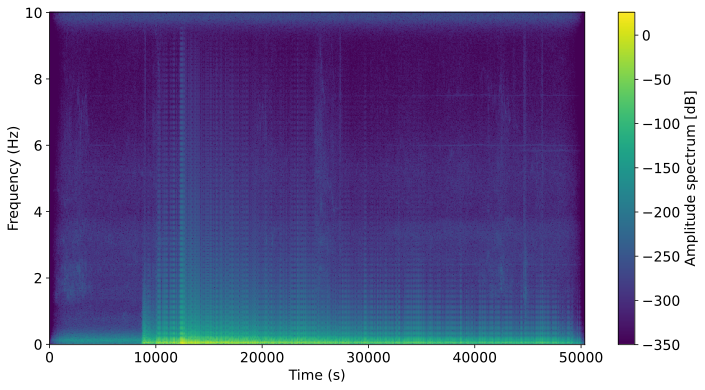

In [38]:
# Let's plot the spectrogram
# notice that the y-axis goes up to half of fs ! i.e. Nyquist frequency
fig, ax = plt.subplots(figsize=(12, 6))
pc = ax.pcolormesh(
    tSTFT, fSTFT, 20 * np.log10(np.absolute(STFT)), rasterized=True, vmin=-350
)  # dB = 20*log() is a convention
# ax.set_ylim([0,fs/8])
ax.set_xlim([0, duration - WindowLength / fs])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pc, label="Amplitude spectrum [dB]")
# try with frequency in log scale:
# ax.semilogy()
# ax.set_ylim(0.001, 10.)


In [27]:
# Future: Make a separate Librosa notebook! 
# Now make a spectrogram with Librosa ! 
# https://librosa.github.io/librosa/generated/librosa.display.specshow.html

# FIRST compute the short time fourier transform: 
#data_stft = librosa.core.stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, 
#                              dtype=<class 'numpy.complex64'>, pad_mode='reflect')[source]

# THEN display it: 
# librosa.display.specshow(data, x_coords=None, y_coords=None, x_axis=None, y_axis=None, sr=22050, hop_length=512, 
# fmin=None, fmax=None, tuning=0.0, bins_per_octave=12, ax=None, **kwargs)[source]
# print(data_n.shape)
# data_stft = np.abs(librosa.stft(data_n, n_fft=int(len(data_n)/1000)) )
# data_stft_l10 = 20*np.log10(data_stft)
# data_stft_db = librosa.amplitude_to_db(data_stft,ref=np.max)
# librosa.display.specshow(data_stft_l10, sr=fs) #, y_axis='log', x_axis='time'


## NOW MAKE SOUND !

In [40]:
OutFileName = FileNameIn[:-4] + "_sonified.wav"

# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead

OriginalDuration = duration
TargetDuration = 3.0  # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print(f"The data is {OriginalDuration:.0f}-second long.")
print(f"Let's make a {TargetDuration:.0f}-second long sound!")

SpeedFactor = OriginalDuration / TargetDuration
print(f"This corresponds to a speed factor of: {SpeedFactor:.0f}.")

# (here we are speeding up the playback because the original content is infrasonic /
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data
#      (time series / spectrum / spectrogram = no change except in the time scale)


The data is 50400-second long.
Let's make a 3-second long sound!
This corresponds to a speed factor of: 16800
This corresponds to a speed factor of: 16800.


In [46]:
# So, set the new sampling rate, and then resample to a standard sampling rate
fs_sound = int(fs*SpeedFactor)
#sr_resample = 44100

#librosa.output.write_wav(DirOut + OutFileName, data_n, 4*fs_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

print(f"We are generating a sound with sampling frequency fs={fs_sound:.0f}Hz.")

ipd.Audio(data_n, rate=fs_sound) 

We are generating a sound with sampling frequency fs=336000Hz.


We are generating a sound with sampling frequency fs=44100Hz.


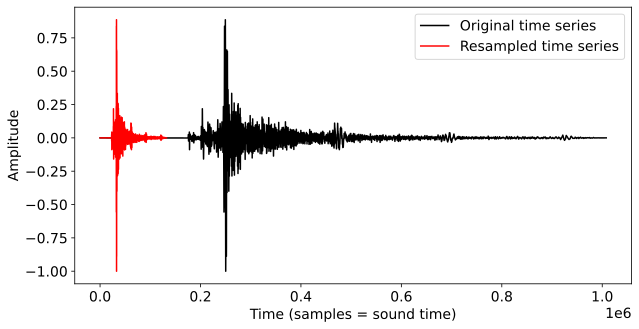

In [47]:
# RESAMPLING
new_fs = 44100 # target sampling frequency in Hz
data_n_rs = resampy.resample(data_n, fs_sound, new_fs)

# plot some to test... replot by sound time...
start = 1000
end = 1000 + 100
fig, ax = plt.subplots(num="waveforms", figsize=(10, 5))
ax.plot(data_n, "k-", label="Original time series")  # [start:end]
ax.plot(data_n_rs, "r-", label="Resampled time series")
ax.set_xlabel("Time (samples = sound time)")
ax.set_ylabel("Amplitude")

ax.legend(loc="upper right")

print(f"We are generating a sound with sampling frequency fs={new_fs:.0f}Hz.")

ipd.Audio(data_n_rs, rate=new_fs)


In [49]:
# write the sound to a .wav file:

outfile_name = f"Tohoku2011_sound_sf{SpeedFactor:.0f}_rs441.wav"
out = DirOut + outfile_name
print(f"The path to the sonified Tohoku-oki earthquake will be: {out}")
# write(out, fs_sound, data_n.astype(np.int16))
write(out, 44100, data_n_rs.astype(np.int16))


The path to the sonified Tohoku-oki earthquake will be: ../output_nogit/Tohoku2011_sound_sf16800_rs441.wav


# =========================================================
# Example 2: Much longer seismic signal: free oscillations 
### filtering to find a hidden signal ! 

#### Their period typically ranges from 20 minutes to a few hours, i.e. a frequency between, say, approximately 0.0002 and 0.002 Hz

### https://vimeo.com/215665951
### http://lucien.saviot.free.fr/terre/index.en.html 

In [50]:
# get the data in:
DirIn = "../data_nogit/seismic_data/"

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = "Sumatra_2004_ANMO_14wks.VHZ"
# Note that this data has been pre-processed (instrument response removal)
fs = 0.1
# Datatype VHZ is downsampled to 0.1 Hz (p=10 s)

data = np.loadtxt(DirIn + FileNameIn)
N_samps = len(data)
duration = N_samps / fs


In [52]:
# make time vectors for plotting purposes only
t = np.arange(0, duration, 1.0 / fs)  # in seconds
t_hours = np.arange(0, duration / 3600, 1.0 / fs / 3600)  # in hours
t_days = np.arange(0, duration / 3600 / 24, 1.0 / fs / 3600 / 24)  # in days

print(f"We have {N_samps} samples at {fs} samples/second.")
print(f"We have {duration:.0f} seconds of data.")
print(f"... which is {duration / 3600.:.1f} hours,")
print(f"... which is {duration / (24. * 3600):.1f} days.")


We have 846720 samples at 0.1 samples/second.
We have 8467200 seconds of data.
... which is 2352.0 hours,
... which is 98.0 days.
We have 8467200 seconds of data...
... which is 2352 hours
... which is 98 days


In [56]:
# Compute the spectrum
data_duration_spl = len(data)
S = spfft.fft(data, len(data))
f = spfft.rfftfreq(len(data), d=1./fs)
# S = S[:int(Nfft/2)]
print(
    "Frequency content ranges from "
    + str(f[0])
    + " to "
    + str(round(f[-1], 3))
    + " Hz..."
)
print(
    "Frequency content ranges from "
    + str(np.log10(f[1]))
    + " to "
    + str(np.log10(f[-1]))
    + " [log10(Hz)]"
)


[1.18102797e-06 1.29913076e-06 1.41723356e-06 ... 4.99996457e-02
 4.99997638e-02 4.99998819e-02] [0.00000000e+00 1.18102797e-07 2.36205593e-07 ... 4.99997638e-02
 4.99998819e-02 5.00000000e-02]
Frequency content ranges from 0.0 to 0.05 Hz...
Frequency content ranges from -6.927739818171388 to -1.3010299956639813 [log10(Hz)]


In [68]:
# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# but keep the value because we want to compare the power to other data... 
maxabs = np.amax(np.absolute(data))
data_n = data/maxabs

ValueError: x and y must have same first dimension, but have shapes (423348,) and (423358,)

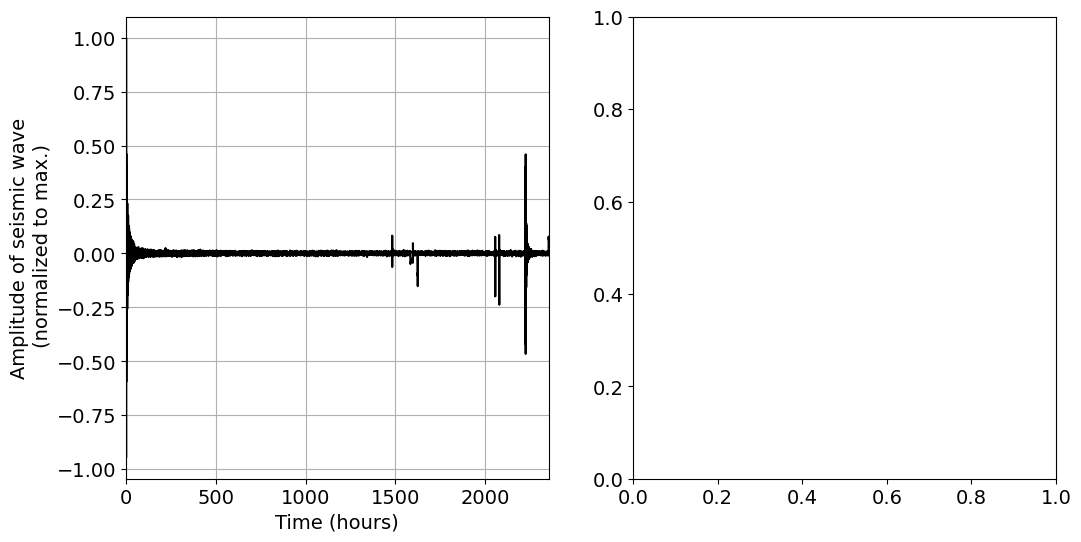

In [70]:
# plot
S = spfft.fft(data_n,Nfft)
S = S[:int(Nfft/2)]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,duration/3600])

plt.subplot(1,2,2)
plt.plot(np.log10(f[1:-1]),20*np.log10(np.absolute(S[1:-1])),'k') 
plt.xlabel('Log Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()

ValueError: x and y must have same first dimension, but have shapes (423350,) and (423360,)

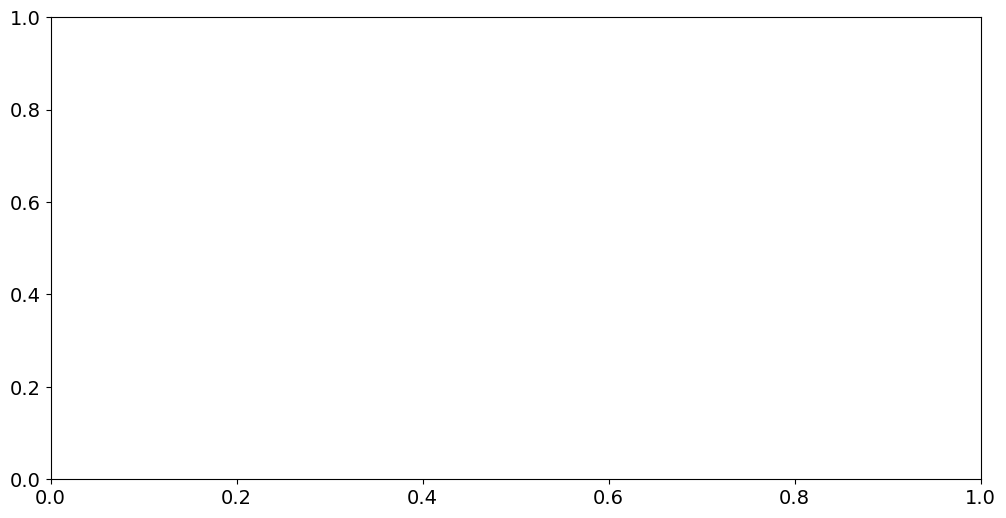

In [58]:
plt.figure(figsize=(12,6))
#plt.plot(np.log10(f),np.log10(np.absolute(S)),'k') 
plt.plot(f,np.absolute(S),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0.0002, 0.002])

window duration in seconds: 84672.0
window length in samples: 8467
16934
(8468, 198)


Text(0, 0.5, 'dB')

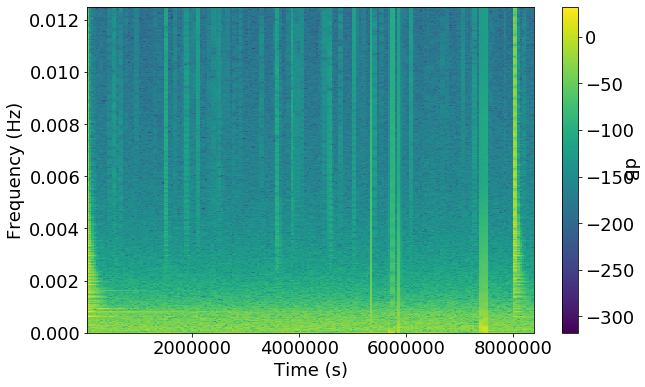

In [37]:
# SPECTROGRAM !
# first compute the short time fourier transform STFT
# "Uncertainty Principle": there is a direct tradeoff between resolution in frequency and in time: 
# that is governed by the window length NfftSTFT

# for the full signal spectra, the Nfft (number of frequencies was simply the length of the signal. 
# instead calculate Nfft upward from the sampling frequency and then window time? 
# 
WindowDur = 300 # in seconds (can calculate this from the lower end of the frequency spectrum that you want to resolve too)
# or 
duration = len(data)/fs
numwindows = 100
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)
# This changes the total number of windows, but has to be smaller than the window length (in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [38]:
outfile_name = '14weeks_Sumatra_nofilt.wav'

OriginalDuration = duration
TargetDuration = 24.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data_n, sr_sound, sr_resample)
# librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound. if so, uncomment: 

# sr_resample = 44100
# dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
# data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
# librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)

The data is 8467200-s long
Let's make a 24.0-second long sound!
This corresponds to a speed factor of: 352800


In [39]:
ipd.Audio(data_rs, rate=fs_sound/2) 

(0.0002, 0.002)

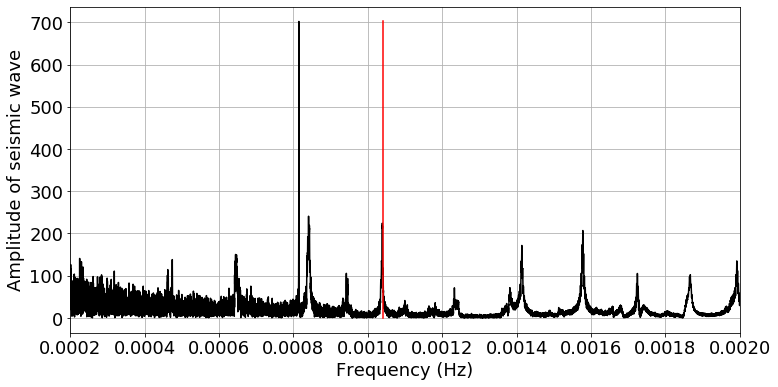

In [40]:
# FILTER AROUND THE MODES ! 

#fcenter = 0.000833333
fcenter = 0.00104
#fcenter = 1/(36*60)

Sabs = np.absolute(S)

plt.figure(figsize=(12,6))
plt.plot(f,Sabs,'k') 
plt.plot([fcenter,fcenter],[0,max(Sabs)],'r-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0.0002, 0.002])

In [41]:
Q = 5 # Quality factor: how wide the filter is around fcenter (higher value damps LESS quickly)
FiltOrder = 2; # Filter Order: (how steep the sides are)


BW_SemiWidth = fcenter/(2*Q)
fmin = fcenter-BW_SemiWidth; 
fmax = fcenter+BW_SemiWidth; 
cutofffreq = np.array([fmin, fmax]) / (fs/2);     

b, a = spsig.butter(FiltOrder, cutofffreq, btype='band', analog=False, output='ba')
w, h = spsig.freqz(b, a); 
w = w*fs/np.pi/2

data_filt = spsig.lfilter(b, a, data)
S_filt = spfft.fft(data_filt,Nfft) # compute the spectrum
S_filt = S_filt[:int(Nfft/2)] # up to the Nyquist frequency

print("Center frequency is: " + "%.02E" %(fcenter) + " Hz")
print("Cut-off frequencies are: " + "%.02E" %(fmin) + " Hz & " + "%.02E" %(fmax) + " Hz")

Center frequency is: 1.04E-03 Hz
Cut-off frequencies are: 9.36E-04 Hz & 1.14E-03 Hz


/Users/onur/.local/share/virtualenvs/pne-bGsmdi4y/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/onur/.local/share/virtualenvs/pne-bGsmdi4y/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/onur/.local/share/virtualenvs/pne-bGsmdi4y/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


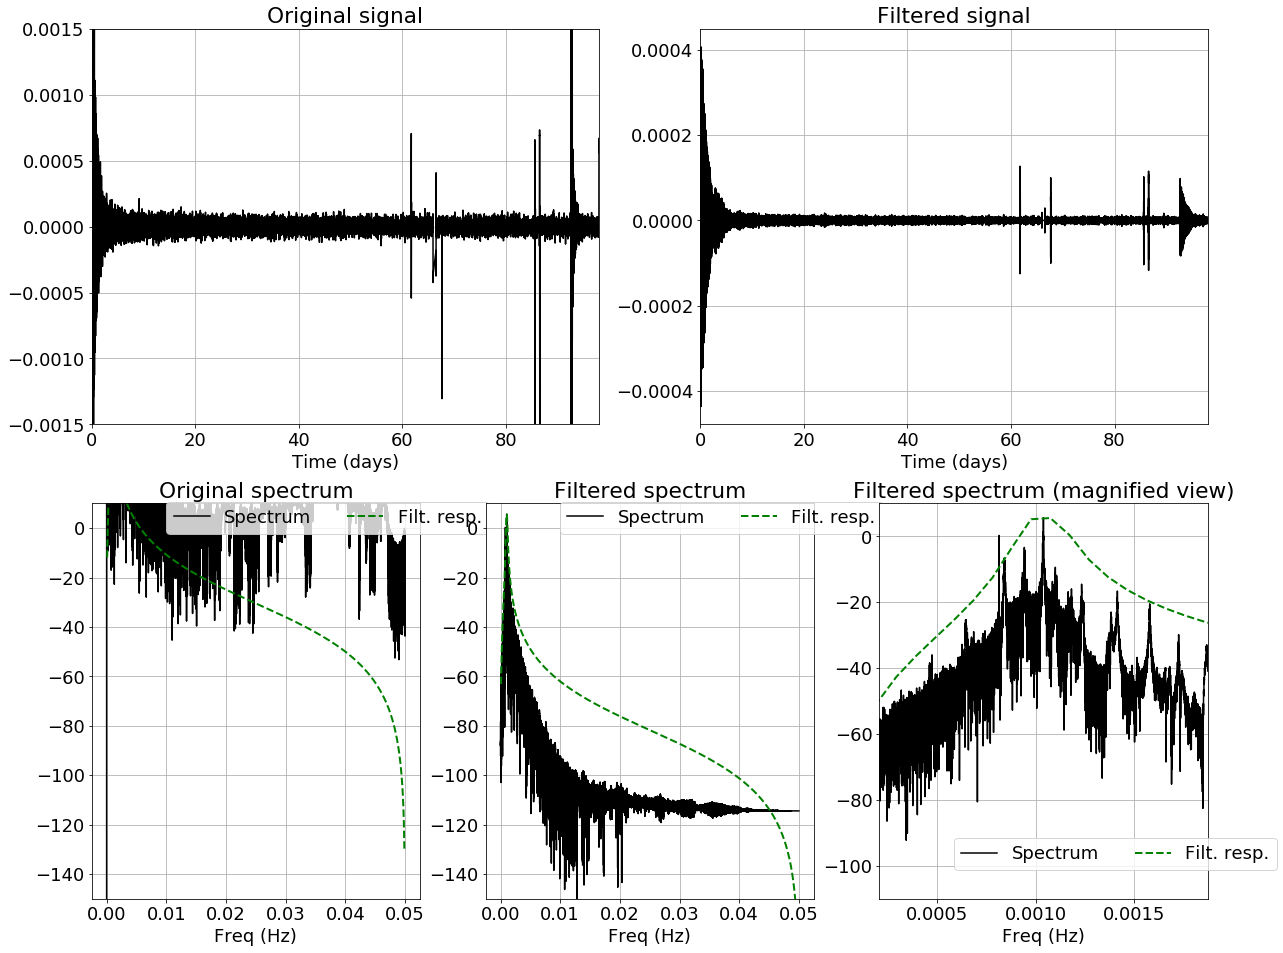

In [42]:
##### Plot and compare original and filtered signals
fig = plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.plot(t_days,data,'k') 
plt.title("Original signal"); plt.xlabel("Time (days)")
plt.ylim([-0.0015, 0.0015])
plt.grid()
plt.xlim([0, duration/3600/24])

plt.subplot(2,2,2)
plt.plot(t_days,data_filt,'k')
plt.title("Filtered signal"); plt.xlabel("Time (days)")
plt.grid()
plt.xlim([0, duration/3600/24])

plt.subplot(2,3,4)
plt.plot(f,20*np.log10(np.abs(S)),'k',label='Spectrum')
plt.plot(w, 20*np.log10(abs(h))+  + 20*np.log10(np.amax(np.abs(S))),'--g',label='Filt. resp.',linewidth=2)
plt.title("Original spectrum"); plt.xlabel("Freq (Hz)")
plt.ylim([-150., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.9), loc=3,ncol=2)

plt.subplot(2,3,5)
plt.plot(f,20*np.log10(np.abs(S_filt)),'k',label='Spectrum')
plt.plot(w, 20 * np.log10(abs(h)) + 20*np.log10(np.amax(np.abs(S_filt))),'--g',label='Filt. resp.',linewidth=2)
plt.title("Filtered spectrum"); plt.xlabel("Freq (Hz)")
plt.ylim([-150., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.9), loc=3,ncol=2)

plt.subplot(2,3,6)
plt.plot(f,20*np.log10(np.abs(S_filt)),'k',label='Spectrum')
plt.plot(w, 20*np.log10(abs(h)) + 20*np.log10(np.amax(np.abs(S_filt))),'--g',label='Filt. resp.',linewidth=2)
plt.xlim([fcenter-8*BW_SemiWidth, fcenter+8*BW_SemiWidth])
plt.title("Filtered spectrum (magnified view)"); plt.xlabel("Freq (Hz)")
plt.ylim([-110., 10.])
plt.grid()
plt.legend(bbox_to_anchor=(0.2, 0.05), loc=3,ncol=2)

# want to save this awesome figure?
#fig.savefig(DirOut + 'SumatraFiltered.png')

window duration in seconds: 84672.0
window length in samples: 8467
16934
(8468, 198)


Text(0, 0.5, 'dB')

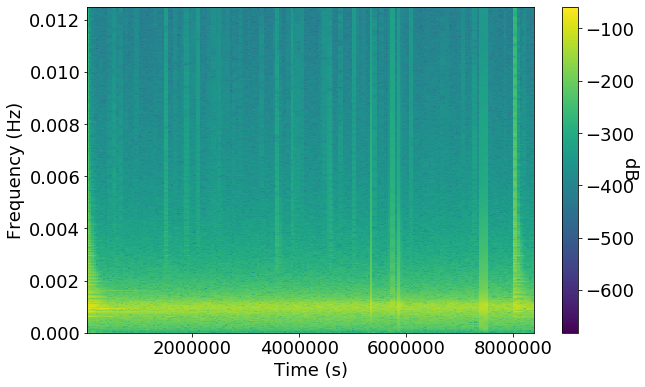

In [43]:
# SPECTROGRAM !

duration = len(data_filt)/fs
numwindows = 100
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

# probably no need to change this. 
Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_filt, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [45]:
# MAKE THE FILTERED SOUND ! 

outfile_name = '14weeks_Sumatra_filt00104.wav'

OriginalDuration = duration
TargetDuration = 14.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data_n, sr_sound, sr_resample)
#librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

ipd.Audio(data_rs, rate=fs_sound/2) 

The data is 8467200-s long
Let's make a 14.0-second long sound!
This corresponds to a speed factor of: 604800


## EXERCISE: Go back and filter it on different modes, 
### play with the speed factor and build a composite sound of several modes, using Audacity, or adding waveforms to each other.   

# =========================================================
# Example 3: LIGO data   
## Laser Interferometer Gravitational-Wave Observatory  (DOI: 10.1103/PhysRevLett.116.061102)
## https://www.ligo.org/
### Much, much much lower amplitude than seismic waves: compare the spectra !
### (too short for direct sonification !)  

In [46]:
# get the data in: 
DirIn = '../data/LIGO/'

# This is the Sumatra earthquake (2004), recorded by a seimic station located in Albuquerque, NM
FileNameIn = 'obs_HanfordWA.txt' 
# https://www.gw-openscience.org/GWTC-1-confident/

data = np.loadtxt(DirIn + FileNameIn)
print(data.shape)
print(data[0,0])
# note that np.loadtext automatically skipped the column headers ! 

time = np.squeeze(data[0:-1,0])
strain = np.squeeze(data[0:-1,1])
print(time.shape)

print(time[-1])
#plt.plot(time-time[0])

duration0 = (time[-1]-time[0])
dt = duration0/len(time) # since we don't a priori know if time is regularly spaced (probably is)
print(duration0)

fs = 1/dt 
print(fs)

#duration = len(data)/fs
#print(duration)

(3441, 2)
0.25
(3440,)
0.45989990234375
0.20989990234375
16388.764175632452


In [47]:
# play it directly ! 
data = strain 

# Compute the spectrum
Nfft = len(data)
#f = np.arange(0,sr/2,sr/Nfft)
f = np.linspace(0,fs/Nfft,round(Nfft/2))
S = spfft.fft(data,Nfft) 
S = S[:int(Nfft/2)]
print(len(f))
print(len(S))
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from [log10] ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' Hz...')

1720
1720
Frequency content ranges from 0.0 to 4.764 Hz...
Frequency content ranges from [log10] -2.557288113213329 to 0.6779877634737232 Hz...


/Users/onur/.local/share/virtualenvs/pne-bGsmdi4y/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


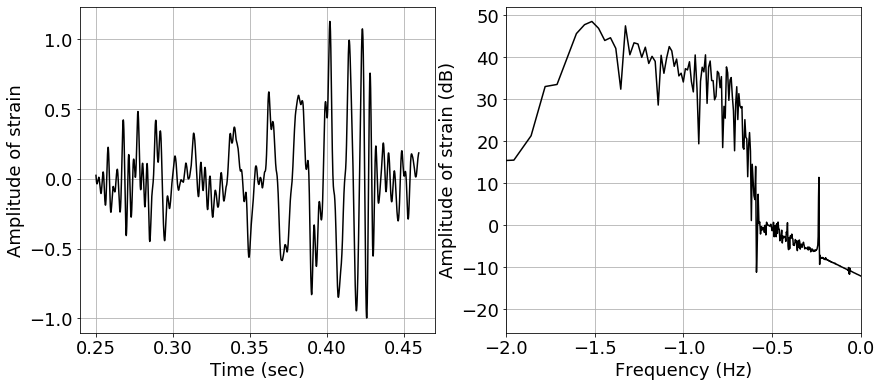

In [48]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(time,data,'k') 
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude of strain')
plt.grid()


plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of strain (dB)')
plt.xlim([-2,0])
plt.grid()

16388.764175632452
window duration in seconds: 0.0104949951171875
window length in samples: 172
344
(173, 39)


Text(0, 0.5, 'dB')

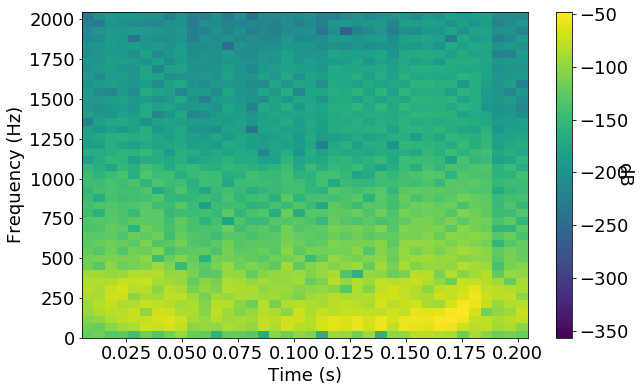

In [49]:
# SPECTROGRAM !
print(fs)
duration = len(data)/fs
numwindows = 20
WindowDur = duration/numwindows


WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
# does this need to be a power of 2 ?  apparently not ! 
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length ! (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

# probably no need to change this. 
Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
# also provides associated f and t vectors!
print(STFT.shape)

# Let's plot the spectrogram
plt.figure(figsize=(10,6))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT)))
plt.ylim([0,fs/8])
#plt.xlim([0,dur1-SliceLength/sr])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

In [50]:
# MAKE THE FILTERED SOUND ! 

outfile_name = 'LIGO_WA_nofilt.wav'

OriginalDuration = duration
TargetDuration = duration/2 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(OriginalDuration) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(SpeedFactor))

# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# resample at 44.100 kHz
sr_resample = 44100
data_rs = resampy.resample(data, sr_sound, sr_resample)
#librosa.output.write_wav(DirOut + outfile_name, data_rs, sr_resample, norm=False)

ipd.Audio(data_rs, rate=fs_sound/8) 

The data is 0.20989990234375-s long
Let's make a 0.104949951171875-second long sound!
This corresponds to a speed factor of: 2.0


## There is not enough data for direct sonification ! 
## We must use other means !  Future notebooks ! 